**Разбор способа отбора модлеи - L2-регуляризация**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder

# Источники

- https://www.statlearning.com/ 6 глава.

# Описание

При L2-регуляризации в целевую функцию метода оценки коэффициентов добавляют компоненнту:

$$\lambda\sum_{j=1}^n\beta^2_j$$

Где:
- $\beta_j$ - оцениваемый коэффициент;
- $\lambda$ - параметр указывающий на сколько сильно следует регуляризовать модель.


L2-регуляризация и регуляризация, в принципе, нужна для того, чтобы модель получала штраф за использование коэффициентов, которые ей на самом деле не нужны.

# Гребеньковая регрессия

## *Описание*

L2-регулялизация в сочетании с регрессионной моделью, называются **гребеньковой регрессией (ridge regression)**. Т.е. целевая функция в задаче оптимизации принимает вид:

$$\sum_{i=1}^n\left(y_i - x_i\beta\right)^2 + \lambda\sum_{j=1}^p\beta_j \rightarrow min$$

Где:
- $n$ - объемы выборки;
- $p$ - размерность данных;
- $x_i = (x_{i1}, x_{i2}, ..., x_{ip})$ - вектор описывающий $i$-е наблюдение;
- $\beta = (\beta_1, \beta_2, ..., \beta_p)$ - вектор оценок коэффициентов.

## *Рекомендуется стандартизация данных*

Перед применением Гребеньковой регрессии данные рекомендуется стандартизовать по формуле.


$$\tilde{x}_{ij} = \frac{x_{ij}}{\sqrt{\frac{1}{n}\sum_{i=1}^n (x_{ij} - \bar{x}_{j})^2}}.$$

Где:
- $\bar{x}_{j}$ - среднее значенте по $j$-му показателю.

# На данных `Credit` рассмотрим как происходит сжатие коэффицентов

Загрузка данных `Credit`

In [2]:
Credit = pd.read_csv("Credit.csv", index_col = 0)

nominal_names = [
    "Gender", "Student", "Married", "Ethnicity"
]

ohe = OneHotEncoder(
    sparse = False, drop = "first"
).fit(
    Credit[nominal_names]
)

Credit = pd.concat(
    [
        pd.DataFrame(
            ohe.transform(Credit[nominal_names]),
            columns = ohe.get_feature_names_out(),
            index= Credit.index
        ),
        Credit.loc[:,~Credit.columns.isin(nominal_names)]
    ],
    axis = 1
)

X = Credit.iloc[:,:-1]
y = Credit.iloc[:, -1]

Credit.head()

,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian,Income,Limit,Rating,Cards,Age,Education,Balance
ID,,,,,,,,,,,,
1,0.0,0.0,1.0,0.0,1.0,14.891,3606,283,2,34,11,333
2,1.0,1.0,1.0,1.0,0.0,106.025,6645,483,3,82,15,903
3,0.0,0.0,0.0,1.0,0.0,104.593,7075,514,4,71,11,580
4,1.0,0.0,0.0,1.0,0.0,148.924,9504,681,3,36,11,964
5,0.0,0.0,1.0,0.0,1.0,55.882,4897,357,2,68,16,331


In [40]:
pd.Series(
    Ridge(alpha = 1).fit(X,y).coef_,
    index = X.columns
)

Gender_Female          -10.153111
Student_Yes            413.899860
Married_Yes             -9.121554
Ethnicity_Asian         16.772873
Ethnicity_Caucasian      9.668260
Income                  -7.796138
Limit                    0.188633
Rating                   1.169353
Cards                   17.495228
Age                     -0.622846
Education               -1.007498
dtype: float64

In [46]:
stand_X = X/np.sqrt(((X - X.mean())**2).sum()/X.shape[0])
coefs = pd.Series(
    Ridge(alpha = 0).fit(stand_X,y).coef_,
    index = X.columns
)
coefs

Gender_Female           -5.323360
Student_Yes            127.724208
Married_Yes             -4.157540
Ethnicity_Asian          7.324290
Ethnicity_Caucasian      5.053449
Income                -274.670668
Limit                  440.099553
Rating                 175.628144
Cards                   24.274738
Age                    -10.576563
Education               -3.429855
dtype: float64

Будем повышать параметр регуляризации и забирать значения коэффициентов. Затем проведем их стандартизацию и нанесем на график.

In [14]:
alphas = np.arange(0, 10000, 10)


In [147]:
coefs = np.array([])

# var_names = ["Income", "Limit", "Rating", "Student"]

for al in alphas:
    model = Ridge(alpha = al).fit(X, y)
    
    coefs = np.concatenate([
        coefs,
        model.coef_
    ])
    
# plot_df = pd.DataFrame(
#     coefs.reshape((len(alphas), len(var_names))),
#     columns = var_names,
#     index = alphas
# )



In [146]:
X.shape[1]

11

In [182]:
plot_df = pd.DataFrame(
    coefs.reshape((len(alphas), X.shape[1])),
    columns = X.columns,
    index = alphas
)

plot_df = (plot_df/ ((((plot_df - plot_df.mean(axis = 0))**2).sum())**(1/2)/plot_df.shape[0]))

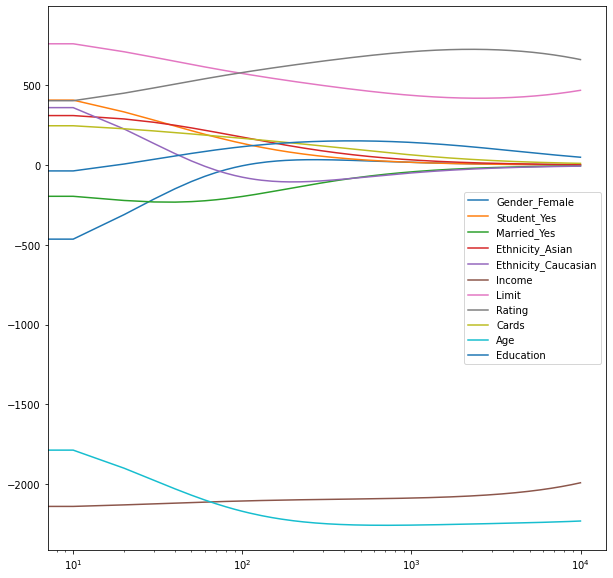

In [183]:
plt.figure(figsize = [10,10])

for col in plot_df:
    plt.plot(plot_df.index, plot_df[col])
    
plt.legend(plot_df.columns)
plt.gca().set_xscale("log")

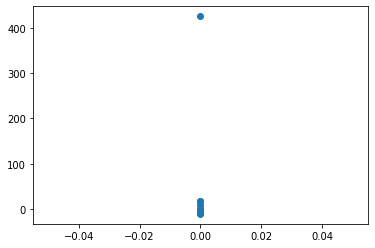

In [187]:
plt.scatter([0]*11, Ridge(alpha = 0).fit(X, y).coef_)

Стандартизация набора данных

In [25]:
stand_X = X/(((X - X.mean())**2).sum()/X.shape[0])

In [26]:
coefs = np.array([])

for al in alphas:
    model = Ridge(alpha = al).fit(stand_X, y)
    
    coefs = np.concatenate([
        coefs,
        model.coef_
    ])
plot_df = pd.DataFrame(
    coefs.reshape((len(alphas), X.shape[1])),
    columns = X.columns,
    index = alphas
)

plot_df = (plot_df/ ((((plot_df - plot_df.mean(axis = 0))**2).sum())**(1/2)/plot_df.shape[0]))

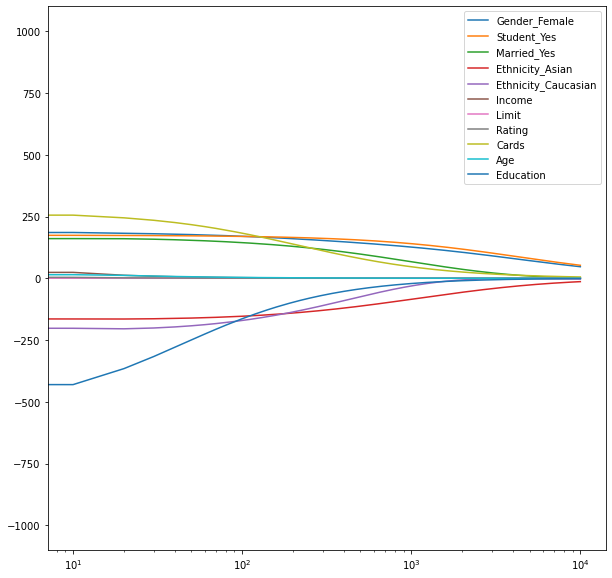

In [27]:
plt.figure(figsize = [10,10])

for col in plot_df:
    plt.plot(plot_df.index, plot_df[col])
    
plt.legend(plot_df.columns)
plt.gca().set_xscale("log")